In [1]:
import gseapy as gp
from gseapy import dotplot
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import omicverse as ov
#import scvelo as scv
import anndata as ad
#from pyslingshot import Slingshot

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=600, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=600, vector_friendly=True)
vector(False)

# SupFigure10A

In [3]:
rna=sc.read_h5ad('/data1/fengyu/methods/scRNA/LUAD_GSE148071/luad_forcellbin.h5ad')

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


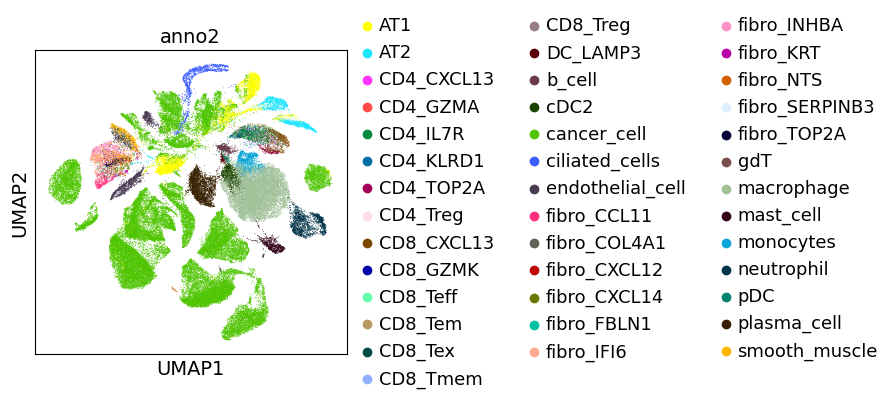

In [4]:
sc.pl.umap(rna, color='anno2', save = 'Sup10A1.pdf')

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


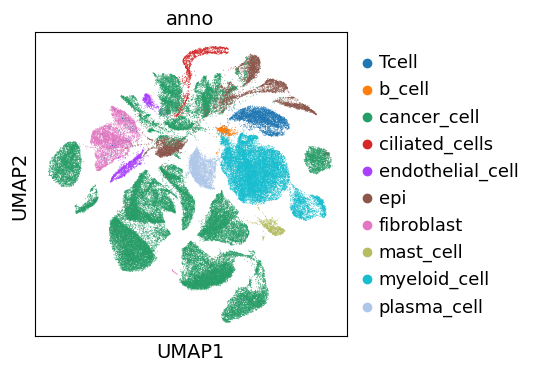

In [5]:
sc.pl.umap(rna, color='anno', save = 'Sup10A2.pdf')

# SupFigure 10B C

In [6]:
cell=sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_cellbin.h5ad')

In [7]:
df = cell.obs

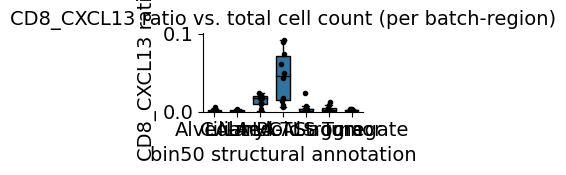

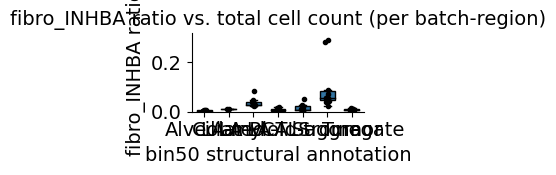

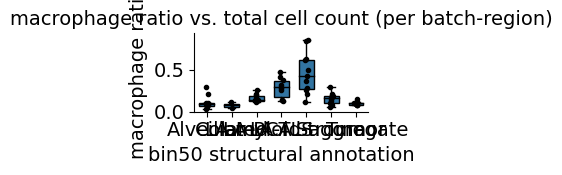

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 假设 df 已存在，且包含所需列
names = ['CD8_CXCL13', 'fibro_INHBA', 'macrophage']

# 1. 计算每个 batch × bin50 的总细胞数
total = (
    df.groupby(['batch', 'bin50 structural annotation'])
      .size()
      .rename('total_cell')
)

for idx, cell_type in enumerate(names, start=1):
    # 2. 当前细胞类型的数量
    cell_cnt = (
        df[df['anno2'] == cell_type]
        .groupby(['batch', 'bin50 structural annotation'])
        .size()
        .rename('cell_cnt')
    )

    # 3. 合并并算比例
    plot_df = (
        pd.concat([total, cell_cnt], axis=1)
          .assign(ratio=lambda x: x['cell_cnt'] / x['total_cell'])
          .reset_index()
          .dropna(subset=['ratio'])          # 防止空值
    )

    # 4. 画图
    fig, ax = plt.subplots(figsize=(3, 2))

    # 按 bin50 分组，保证顺序一致
    grouped = plot_df.groupby('bin50 structural annotation')['ratio']
    box_data = [g.values for _, g in grouped]
    labels   = list(grouped.groups.keys())

    # 4-1 boxplot
    bp = ax.boxplot(
        box_data,
        positions=range(len(labels)),
        widths=0.6,
        patch_artist=True,
        showfliers=False
    )
    for patch in bp['boxes']:
        patch.set_facecolor('#3274A1')   # 蓝色箱体
        patch.set_edgecolor('black')
    for med in bp['medians']:
        med.set_color('black')
    for whisk in bp['whiskers']:
        whisk.set_color('black')
    for cap in bp['caps']:
        cap.set_color('black')

    # 4-2 stripplot（黑色散点）
    for pos, vec in zip(range(len(labels)), box_data):
        jitter = pos + np.random.normal(0, 0.04, len(vec))
        ax.scatter(jitter, vec, color='black', s=9, zorder=3)

    # 4-3 美化
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel('bin50 structural annotation')
    ax.set_ylabel(f'{cell_type} ratio')
    ax.set_title(f'{cell_type} ratio vs. total cell count (per batch-region)')
    ax.set_ylim(0, plot_df['ratio'].max() * 1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()
    plt.grid(False)

    # 5. 保存
    fig.savefig(f'Sup10B{idx}.pdf', bbox_inches='tight')
    plt.show()     # 释放内存

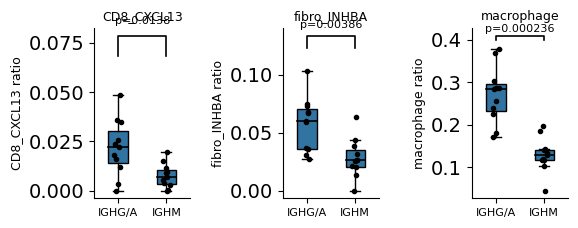

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# 假设 df 已在环境中
anno2_list = ['CD8_CXCL13', 'fibro_INHBA', 'macrophage']

# 总细胞数
total = (
    df.groupby(['batch', 'LA_anno'])
      .size()
      .rename('total_cell')
)

with PdfPages('Sup10D1-4.pdf') as pdf:
    fig, axes = plt.subplots(1, 3, figsize=(6, 2.5), sharey=False)

    for idx, cell_type in enumerate(anno2_list):
        # 当前类细胞数
        cls_cnt = (
            df[df['anno2'] == cell_type]
            .groupby(['batch', 'LA_anno'])
            .size()
            .rename('cls_cnt')
        )

        # 合并、计算比例、保留两类
        plot_df = (
            pd.concat([total, cls_cnt], axis=1)
              .assign(cls_ratio=lambda x: x['cls_cnt'] / x['total_cell'])
              .reset_index()
        )
        plot_df = plot_df[plot_df['LA_anno'].isin(['PCA_IGHG/A','PCA_IGHM'])]

        # Mann–Whitney U
        b = plot_df.loc[plot_df['LA_anno'] == 'PCA_IGHG/A', 'cls_ratio'].dropna()
        a = plot_df.loc[plot_df['LA_anno'] == 'PCA_IGHM', 'cls_ratio'].dropna()
        u_stat, p_val = stats.mannwhitneyu(a, b, alternative='two-sided')

        ax = axes[idx]

        # 准备 x 轴位置
        x_pos = np.arange(2)
        labels = [ 'PCA_IGHG/A','PCA_IGHM']

        # boxplot
        box_data = [b.values, a.values]          # 与 labels 顺序一致
        bp = ax.boxplot(box_data,
                        positions=x_pos,
                        widths=0.4,
                        patch_artist=True,
                        showfliers=False)        # 不画异常值，strip 会画
        for patch in bp['boxes']:
            patch.set_facecolor('#3274A1')
            patch.set_edgecolor('black')
            patch.set_linewidth(1)
        for whisk in bp['whiskers']:
            whisk.set_color('black')
            whisk.set_linewidth(1)
        for cap in bp['caps']:
            cap.set_color('black')
            cap.set_linewidth(1)
        for med in bp['medians']:
            med.set_color('black')
            med.set_linewidth(1.2)

        # stripplot (散点)
        for x, vec in zip(x_pos, box_data):
            # 添加一点水平抖动
            jittered = x + np.random.normal(0, 0.04, size=len(vec))
            ax.scatter(jittered, vec,
                       color='black',
                       s=9,
                       zorder=3)

        # 显著性线
        x1, x2 = 0, 1
        y_max = plot_df['cls_ratio'].max()
        bar_height = y_max + 0.02
        ax.plot([x1, x1, x2, x2],
                [bar_height, bar_height + 0.01, bar_height + 0.01, bar_height],
                lw=1.2, c='black')
        ax.text((x1 + x2) / 2, bar_height + 0.015, f'p={p_val:.3g}',
                ha='center', va='bottom', fontsize=8)

        # 轴标签
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['IGHG/A','IGHM', ], fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel(f'{cell_type} ratio', fontsize=9)
        ax.set_title(cell_type, fontsize=9)

        # 去掉多余边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)

    plt.tight_layout()
   
    pdf.savefig(fig)
    plt.show()

# Sup10 D

In [13]:
adata11 = sc.read_h5ad('/data1/fengyu/methods/zy/P5_D06053D2_ananlysis/Latest_analysis_6.12/readid4/Final_D06053D2_after_processed_cellbin.h5ad')
tissue_outline=pd.DataFrame(adata11.uns['tissue_outline'],columns=['x','y'])

In [14]:
# 假设 adata9 已经完成降维并保存在 .obsm['X_umap'] 里
umap_coords = pd.DataFrame(
    adata11.obsm['X_umap'][:, :2],
    index=adata11.obs_names,
    columns=['UMAP_1', 'UMAP_2']
)

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


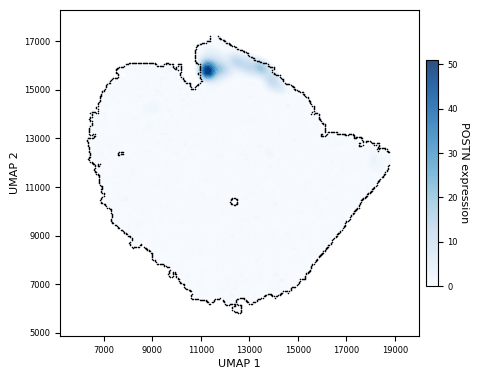

In [16]:
#提取 MMP14 表达（兼容稀疏/稠密矩阵）
if hasattr(adata11.X, 'toarray'):
    mmp14_expr = adata11[:, 'POSTN'].X.toarray().flatten()
else:
    mmp14_expr = adata11[:, 'POSTN'].X.A.flatten() if hasattr(adata11.X, 'A') else adata9[:, 'POSTN'].X

plot_df = pd.DataFrame({
    'UMAP_1': umap_coords['UMAP_1'],
    'UMAP_2': umap_coords['UMAP_2'],
    'POSTN': mmp14_expr
})

# -------------------------------------------------
# 2. 画图
# -------------------------------------------------

fig, ax = plt.subplots(figsize=(5, 4))

# 2.1 散点图（颜色映射到 MMP14）
scatter = ax.scatter(
    plot_df['UMAP_1'],
    plot_df['UMAP_2'],
    c=plot_df['POSTN'],
    cmap='Blues',
    s=5,
    alpha=0.85
)

# 2.2 可选：在表达>0的细胞上画密度轮廓
sns.kdeplot(
    data=plot_df[plot_df['POSTN'] > 0],
    x='UMAP_1',
    y='UMAP_2',
    weights='POSTN',
    fill=True,
    cmap='Blues',
    alpha=1,
    levels=30,
    bw_adjust=0.3,
    thresh=0.5,
    linewidths=0.5,
)

# 2.3 可选：添加组织轮廓
sns.scatterplot(
    data=tissue_outline,
    x='x', y='y',
    color='black',
    s=1,
    edgecolor=None,
)

# 2.4 美化
#ax.set_axis_off()
# -------------------------------------------------
# 2.4 美化（改为显示坐标轴与刻度）
# -------------------------------------------------
# -------------------------------------------------
# 2.4 美化（坐标轴范围 + 刻度）
# -------------------------------------------------
ax.set_xlabel('UMAP 1', fontsize=8, labelpad=3)
ax.set_ylabel('UMAP 2', fontsize=8, labelpad=3)

# 设置坐标轴范围
ax.set_xlim(5000, 20000)
ax.set_ylim(5000, 20000)

# 设置刻度位置和标签
ax.set_xticks(range(5000, 20001, 2000))
ax.set_yticks(range(5000, 20001, 2000))   # 你写的是 20 000 步长，这里按 2000 写了；如确实需要 20 000 步长，把 2000 换成 20000 即可

ax.tick_params(axis='both', which='major', labelsize=6)
plt.grid(False)
plt.axis('equal')

# 2.5 添加 colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.02, fraction=0.03, shrink=0.7)
cbar.set_label('POSTN expression', rotation=270, labelpad=8, fontsize=8)
cbar.ax.tick_params(labelsize=6)

plt.tight_layout()

plt.savefig('sup106D_POSTN.pdf', dpi=600, bbox_inches='tight',transparent=False)
plt.show()